# Import packages & data

## Import packages

In [116]:
#standard packages
import re
import pandas as pd
import numpy as np

#NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Load SpaCy's embedding model
import spacy 
nlp = spacy.load('en_core_web_lg')

#Sklearn
from sklearn import preprocessing

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Clustering
import umap
import hdbscan

## Import data

In [2]:
data = pd.read_csv('Q2_jobdata.csv', encoding='iso-8859-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 26 columns):
jobpost                 19001 non-null object
date                    19001 non-null object
Title                   18973 non-null object
Company                 18994 non-null object
AnnouncementCode        1208 non-null object
Term                    7676 non-null object
Eligibility             4930 non-null object
Audience                640 non-null object
StartDate               9675 non-null object
Duration                19001 non-null object
Location                18969 non-null object
JobDescription          15109 non-null object
JobRequirment           16479 non-null object
RequiredQual            18517 non-null object
Salary                  9622 non-null object
ApplicationP            18941 non-null object
OpeningDate             18295 non-null object
Deadline                18936 non-null object
Notes                   2211 non-null object
AboutC                  1

# Data preperation

## Remove empty cells

In [3]:
#Remove empty cells in target column
data = data.dropna(subset=['Title', 'JobDescription', 'Year', 'jobpost'])
print('Empty Cells Removed')
data.info()

Empty Cells Removed
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15090 entries, 0 to 19000
Data columns (total 26 columns):
jobpost                 15090 non-null object
date                    15090 non-null object
Title                   15090 non-null object
Company                 15090 non-null object
AnnouncementCode        970 non-null object
Term                    6695 non-null object
Eligibility             3614 non-null object
Audience                459 non-null object
StartDate               7932 non-null object
Duration                15090 non-null object
Location                15078 non-null object
JobDescription          15090 non-null object
JobRequirment           13128 non-null object
RequiredQual            15081 non-null object
Salary                  8103 non-null object
ApplicationP            15090 non-null object
OpeningDate             14608 non-null object
Deadline                15072 non-null object
Notes                   1685 non-null object
AboutC

## Remove stopwords, lowercase, punctuation and lemma

In [4]:
def remove_stopwords (text):
#To remove stopwords from text.
#Input:text; Return:text
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    return ' '.join([x for x in word_tokens if x.lower() not in stop_words])

def convert_lowercase (text):
#To convert all text into lowercase.
#Input:text; Return:text
    return text.lower()
    
def convert_singular(text):
#To convert pural words to singular words. 
#Input:text; Return:text
    lmtzr = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    tokens = [token.lower() for token in word_tokens]
    return (' ').join([lmtzr.lemmatize(token) for token in tokens])

def remove_punctuation (desc):
#To remove all punctuation from text. 
#Input:text; Return:text    
    new = re.sub(r'[^\w]', ' ', desc)
    new = re.sub(r'   ', ' ', new)
    new = re.sub(r'www', ' ', new)
    return new

In [5]:
#Preprocessing Text
#Clean Job Post
data['Cleaned Job Post'] = data['jobpost'].apply(remove_stopwords)
data['Cleaned Job Post'] = data['Cleaned Job Post'].apply(remove_punctuation)
data['Cleaned Job Post'] = data['Cleaned Job Post'].apply(convert_singular)
data['Cleaned Job Post'] = data['Cleaned Job Post'].apply(convert_lowercase)
print('Preprocess Completed: Job Post')
#Clean up Job Title
data['Cleaned Job Title'] = data['Title'].apply(remove_stopwords)
data['Cleaned Job Title'] = data['Cleaned Job Title'].apply(remove_punctuation)
data['Cleaned Job Title'] = data['Cleaned Job Title'].apply(convert_singular)
data['Cleaned Job Title'] = data['Cleaned Job Title'].apply(convert_lowercase)
print('Preprocess Completed: Job Title')
#Clean Job Description
data['Cleaned Job Description'] = data['JobDescription'].apply(remove_stopwords)
data['Cleaned Job Description'] = data['Cleaned Job Description'].apply(remove_punctuation)
data['Cleaned Job Description'] = data['Cleaned Job Description'].apply(convert_singular)
data['Cleaned Job Description'] = data['Cleaned Job Description'].apply(convert_lowercase)
print('Preprocess Completed: Job Description')

Preprocess Completed: Job Post
Preprocess Completed: Job Title
Preprocess Completed: Job Description


## Create new dataframe with target column

In [6]:
#Create new dataframe with cleaned column
cleaned_data = data[['Year','Cleaned Job Post', 'Cleaned Job Title', 'Cleaned Job Description']]
cleaned_data = cleaned_data.reset_index(drop=True)
cleaned_data.head()

,Year,Cleaned Job Post,Cleaned Job Title,Cleaned Job Description
0,2004,ameria investment consulting company job title...,chief financial officer,ameria investment consulting company seeking c...
1,2004,caucasus environmental ngo network cenn job ti...,country coordinator,public outreach strengthening growing network ...
2,2004,manoff group job title bcc specialist position...,bcc specialist,lead local enhancement development health bcc ...
3,2004,boutique appollo job title saleswoman position...,saleswoman,saleswoman sell menswear accessory
4,2004,osi assistance foundation armenian branch offi...,chief accountant finance assistant,armenian branch office open society institute ...


## Remove custom stopwords

###  Count top words

In [7]:
#Count most used words for
def count_words(text):
#To count the number of words.
#Input:text; Return:text
    wordcount = {}
    for i in text.lower().split():
        if i in wordcount: 
            wordcount[i] += 1
        else:
            wordcount[i] = 1      
    sorted_wordcount = sorted(wordcount.items(), key=lambda x: x[1], reverse=True)
    return sorted_wordcount

In [8]:
#Count Job post, description and title
#Job Post
all_jobpost = ' '.join(cleaned_data['Cleaned Job Post'].values)
all_jobpost = ' '.join(all_jobpost.split())
jobpost_wordcount = count_words(all_jobpost)
print('Word Count Completed: Job Post')
print jobpost_wordcount[0:25]

#Job Title
all_title = ' '.join(cleaned_data['Cleaned Job Title'].values)
all_title = ' '.join(all_title.split())
title_wordcount = count_words(all_title)
print('Word Count Completed: Job Desc')
print title_wordcount[0:50]

#Job Description
all_description = ' '.join(cleaned_data['Cleaned Job Description'].values)
all_description = ' '.join(all_description.split())
description_wordcount = count_words(all_description)
print('Word Count Completed: Job Desc')
print description_wordcount[0:25]

Word Count Completed: Job Post
[(u'job', 62233), (u'application', 59440), (u'armenia', 34460), (u'am', 33768), (u'experience', 33415), (u'please', 33079), (u'mention', 32890), (u'opportunity', 32743), (u'website', 32701), (u'career', 32031), (u'knowledge', 31829), (u'careercenter', 31144), (u'work', 29090), (u'skill', 27915), (u'company', 26784), (u'related', 24993), (u'date', 23432), (u'development', 23299), (u'organization', 23236), (u'project', 22252), (u'ability', 20531), (u'letter', 20516), (u'procedure', 19894), (u'required', 19612), (u'yerevan', 19602)]
Word Count Completed: Job Desc
[(u'manager', 2094), (u'developer', 1829), (u'specialist', 1546), (u'engineer', 1366), (u'senior', 1264), (u'assistant', 1042), (u'software', 1007), (u'sale', 656), (u'officer', 615), (u'department', 610), (u'accountant', 593), (u'project', 570), (u'marketing', 465), (u'development', 464), (u'coordinator', 432), (u'director', 429), (u'chief', 425), (u'c', 408), (u'expert', 379), (u'web', 377), (u'ad

### Create custom stopwords
Remove noise from the top words of all job post, title and description.

In [9]:
#With this some words are selected that may help in clearing up the clustering.
custom_stopwords = [
    'ability',
    'activity',
    'application',
    'announcement',
    'armenia',
    'am',
    'annoucement',   
    'company',
    'candidate',
    'careercenter',
    'deadline',
    'ensure',
    'follow',
    'he',
    'incumbent',
    'job',
    'llc',
    'mention',
    'organization',
    'please',
    'position',
    'responsible', 
    'responsibility',
    'support',
    'seeking',
    's',
    'looking',
    'team',
    'thanks',
    'url',
    'work',
    'website',
    'yerevan',
]

### Remove custom stopwords
Remove custom stopwords from job post, title and description. 

In [10]:
def remove_custom_stopwords(description):
#To remove custom stopwords.
#Input:text; Return:text
    return ' '.join([x for x in description.split() if x.lower() not in custom_stopwords])

In [11]:
#Remove custom stopwords
#Job Post
cleaned_data['Cleaned Job Post'] = cleaned_data.apply(lambda row: remove_custom_stopwords(row['Cleaned Job Post']), axis=1)
print("Custom Stopwords Removed: Job Post")

#Job Title
cleaned_data['Cleaned Job Title'] = cleaned_data.apply(lambda row: remove_custom_stopwords(row['Cleaned Job Title']), axis=1)
print("Custom Stopwords Removed: Job Title")

#Job Description
cleaned_data['Cleaned Job Description'] = cleaned_data.apply(lambda row: remove_custom_stopwords(row['Cleaned Job Description']), axis=1)
print("Custom Stopwords Removed: Job Description")

Custom Stopwords Removed: Job Post
Custom Stopwords Removed: Job Title
Custom Stopwords Removed: Job Description


In [12]:
cleaned_data.head(10)

,Year,Cleaned Job Post,Cleaned Job Title,Cleaned Job Description
0,2004,ameria investment consulting title chief finan...,chief financial officer,ameria investment consulting chief financial o...
1,2004,caucasus environmental ngo network cenn title ...,country coordinator,public outreach strengthening growing network ...
2,2004,manoff group title bcc specialist location man...,bcc specialist,lead local enhancement development health bcc ...
3,2004,boutique appollo title saleswoman location hou...,saleswoman,saleswoman sell menswear accessory
4,2004,osi assistance foundation armenian branch offi...,chief accountant finance assistant,armenian branch office open society institute ...
5,2004,american embassy number 04 01 title program as...,program assistant inl fsn 8 fp 6,assist coordinating inl funded law enforcement...
6,2004,institute sustainable community isc title chie...,chief party cop,isc seek experienced creative chief party cop ...
7,2004,food security regional cooperation stability p...,community development capacity building conflict,food security regional cooperation stability p...
8,2004,united nation development programme title coun...,country economist nob,united nation development programme announces ...
9,2004,counterpart international inc counterpart comm...,driver logistics assistant,driver logistics assistant full time national ...


# Generate vectors
Create 3 vectors for each job posting: 
- Average word embedding for the job title, job description and the entire job post.

In [13]:
vectorsTitles        = []
vectorsDescriptions  = []
vectorsJobPosts      = []
counter = 0 

print ('Generating Vectors. Progress below:')
for index, row in cleaned_data.iterrows():    
    vectorsTitles.append(nlp(row['Cleaned Job Title']).vector)    
    vectorsDescriptions.append(nlp(row['Cleaned Job Description']).vector)
    vectorsJobPosts.append(nlp(row['Cleaned Job Post']).vector)
    
    #show progress every 1000.
    counter = counter + 1
    if counter % 5000 == 0:
        print(counter)    
        
print('Vectors Generated')

Generating Vectors. Progress below:
5000
10000
15000
Vectors Generated


# UMAP and HDBSCAN

In [66]:
#Ideal parameters. These are the values to experiment with to fit with different datasets.
n_neighbors=40
min_cluster_size=100

In [67]:
#Concatenate arrays 
new_vectors = np.concatenate([vectorsTitles, vectorsDescriptions, vectorsJobPosts], axis=1)
np.shape(new_vectors)

(15090, 900)

## Create umap reducer

In [76]:
# Create UMAP reducer
reducer = umap.UMAP(n_neighbors=n_neighbors)
embeddings = reducer.fit_transform(new_vectors)

## Create hdbscan clusters
HDBSCAN determines the number of clusters, there will be some votality with each re-run.
Save the clusters, once there is something that works. 

In [77]:
# Create HDBSCAN clusters
hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
score_titles = hdb.fit(embeddings)
cluster_titles = score_titles.labels_
print("HDB Completed")

HDB Completed


## Cluster: illustration & summary 
Summary: Number of clusters, unclustered values. 
Illustration: View clusters in a scatter chart as well as in dataframe. 

In [78]:
#Cluster information. 
num_clusters = cluster_titles.max()
uncluster_titles = list(cluster_titles).count(-1)

print 'Total number of clusters:', num_clusters
print "Unclustered values: ", uncluster_titles
print "Total Values: ", len(list(cluster_titles))
print "Data usage: {0:.2f}".format((len(list(cluster_titles)) - list(cluster_titles).count(-1)) / len(list(cluster_titles)))

Total number of clusters: 25
Unclustered values:  5830
Total Values:  15090
Data usage: 0.00


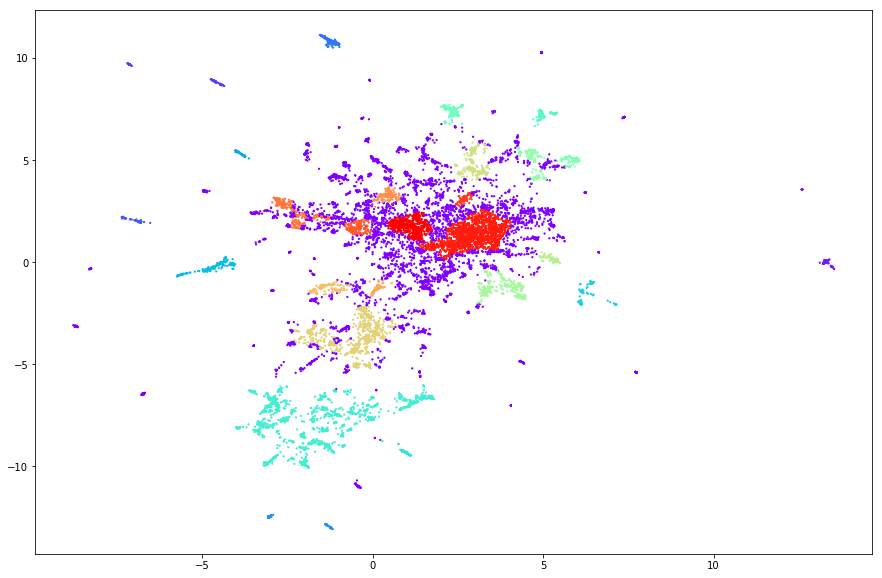

In [79]:
#scatter chart to illustrate clusters
%matplotlib inline
fig, axs = plt.subplots(nrows=1, figsize=(15,10))
plt.scatter(embeddings[:, 0], embeddings[:, 1],  s=1.5, cmap='rainbow', c=cluster_titles)

In [80]:
#illustrate job title in one cluster, e.g cluster 2 and in dataframe e.g cluster 3.
clustered_data = cleaned_data
clustered_data['cluster'] = cluster_titles
clustered_data[clustered_data['cluster'] == 2]['Cleaned Job Title'].head(n=10)

74                translator interpreter avet3
138                         translator general
141    translator telecommunication regulatory
370                     translator interpreter
372                                 translator
375                     translator interpreter
502                                 translator
570                                 translator
572                     translator interpreter
613               freelance english translator
Name: Cleaned Job Title, dtype: object

In [81]:
clustered_data[clustered_data['cluster'] == 3].head(n=10)

,Year,Cleaned Job Post,Cleaned Job Title,Cleaned Job Description,cluster
37,2004,sef international universal credit organisatio...,accountant,sef international growing universal credit rec...,3
56,2004,center community dialogue initiative ccdi titl...,accountant,accountant full time national staff based ccdi...,3
162,2004,armenian forest ngo title accountant term part...,accountant,armenian forest ngo funding tufenkian foundati...,3
178,2004,qsi international school title accountant term...,accountant,qsi international school seek one part time fu...,3
291,2004,h b ltd title accountant location description ...,accountant,accountancy financial management,3
296,2004,hovbilt brick ltd title accountant location gy...,accountant,highly motivated person fulfill accountant,3
361,2004,world vision title accountant open to eligibil...,accountant,assist maintaining financial record preparing ...,3
461,2004,education sustainable development foundation t...,accountant,esdf currently seek fill part time accountant ...,3
478,2004,bem ngo title accountant code 137503 term part...,accountant,role accountant provide comprehensive professi...,3
491,2004,medulla title accountant location tbilisi geor...,accountant,medulla chemotherapy immunotherapy clinic anno...,3


## Save cluster
Export cluster data into csv. 

In [82]:
#Export data. 
clustered_data.to_csv('clustered_data.csv', index=False)

# Identifying the top clusters

## View clusters and its content. 

In [136]:
clustered_data = pd.read_csv('clustered_data.csv')

wordcount = {}
sorted_wordcount = {}
print ('Clusters and its content (e.g. top words):')
for i in range(max(clustered_data['cluster'].unique()) + 1):
    titles = clustered_data[clustered_data['cluster'] == i]["Cleaned Job Title"].values
    titles = ' '.join(' '.join(titles).split())
    wordcount[i] = {}
    for j in titles.lower().split():
        if j in wordcount[i]: 
            wordcount[i][j] += 1
        else:
            wordcount[i][j] = 1
        
    sorted_wordcount[i] = sorted(wordcount[i].items(), key=lambda x: x[1], reverse=True)
    print ('Cluster:') + str(i), sorted_wordcount[i][0:5]

Clusters and its content (e.g. top words):
Cluster:0 [('lawyer', 125), ('moderator', 15), ('advocate', 4), ('attorney', 1)]
Cluster:1 [('receptionist', 131), ('assistant', 88), ('administrative', 81), ('admin', 4), ('operational', 2)]
Cluster:2 [('translator', 107), ('interpreter', 54), ('piu', 5), ('technical', 3), ('freelance', 3)]
Cluster:3 [('accountant', 260), ('outsourcing', 4), ('capex', 2), ('auditor', 2), ('specialist', 1)]
Cluster:4 [('developer', 62), ('io', 61), ('programmer', 50), ('senior', 24), ('mobile', 5)]
Cluster:5 [('language', 92), ('english', 77), ('teacher', 29), ('specialist', 26), ('instructor', 24)]
Cluster:6 [('medical', 261), ('representative', 240), ('gyumri', 7), ('manager', 5), ('general', 4)]
Cluster:7 [('writer', 52), ('translator', 52), ('language', 44), ('technical', 40), ('editor', 36)]
Cluster:8 [('developer', 140), ('software', 138), ('programmer', 7), ('embedded', 2), ('backend', 2)]
Cluster:9 [('developer', 1491), ('senior', 504), ('c', 372), ('s

## Manual clean up (Optional)
Merge similiar clusters. 

In [137]:
def mergeClusters(merge_target, origin):
#To merge similiar clusters.
#Input:text; Return:text
    clustered_data.loc[clustered_data['cluster'] == merge_target, 'cluster'] = origin
    sorted_wordcount[origin] = sorted_wordcount[merge_target]
    sorted_wordcount.pop(merge_target, None)

In [138]:
#Programmers, Developers, Networking
mergeClusters(8, 4)
mergeClusters(9, 4)
mergeClusters(18, 4)

#Quality Assurance
mergeClusters(19, 17)

#Lawyer
mergeClusters(23, 0)

#Finance & Accounting
mergeClusters(11, 3)
mergeClusters(16, 3)
mergeClusters(25, 3)

#Sales & marketing
mergeClusters(21, 14)

#Office executive
mergeClusters(12, 13)

#Project Manager
mergeClusters(24, 15)

## Cluster Summary 
View the top word for each cluster. 

In [141]:
firsttopword = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ")
    print sorted_wordcount[key][0]
    
    firsttopword[key] = [k for k in sorted_wordcount[key][0]][0]

Cluster 0: 
('legal', 77)
Cluster 1: 
('receptionist', 131)
Cluster 2: 
('translator', 107)
Cluster 3: 
('specialist', 305)
Cluster 4: 
('administrator', 197)
Cluster 5: 
('language', 92)
Cluster 6: 
('medical', 261)
Cluster 7: 
('writer', 52)
Cluster 10: 
('hr', 134)
Cluster 13: 
('administrative', 208)
Cluster 14: 
('sale', 325)
Cluster 15: 
('specialist', 277)
Cluster 17: 
('quality', 105)
Cluster 20: 
('branch', 140)
Cluster 22: 
('service', 125)


In [146]:
clusterList = list(clustered_data['cluster'].unique())
clusterList.remove(-1)
print 'The clusters available afer merging are as of below:'
print(clusterList)

The clusters available afer merging are as of below:
[3, 15, 4, 13, 14, 1, 6, 5, 7, 2, 17, 0, 20, 22, 10]


In [ ]:
datecount = {}
for i in clusterList:
    dates = clustered_data[clustered_data['cluster'] == i]['Year'].values
    datecount[i] = {}
    for jobdate in dates:
        if jobdate in datecount[i]: 
            datecount[i][jobdate] += 1
        else:
            datecount[i][jobdate] = 1
datedf = pd.DataFrame(datecount)

# fill in NaN's
datedf.fillna(value=0, inplace=True)

## Normalized to see trends. 

In [143]:
x = datedf.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normdf = pd.DataFrame(x_scaled)

In [144]:
firsttopword

{0: 'legal',
 1: 'receptionist',
 2: 'translator',
 3: 'specialist',
 4: 'administrator',
 5: 'language',
 6: 'medical',
 7: 'writer',
 10: 'hr',
 13: 'administrative',
 14: 'sale',
 15: 'specialist',
 17: 'quality',
 20: 'branch',
 22: 'service'}

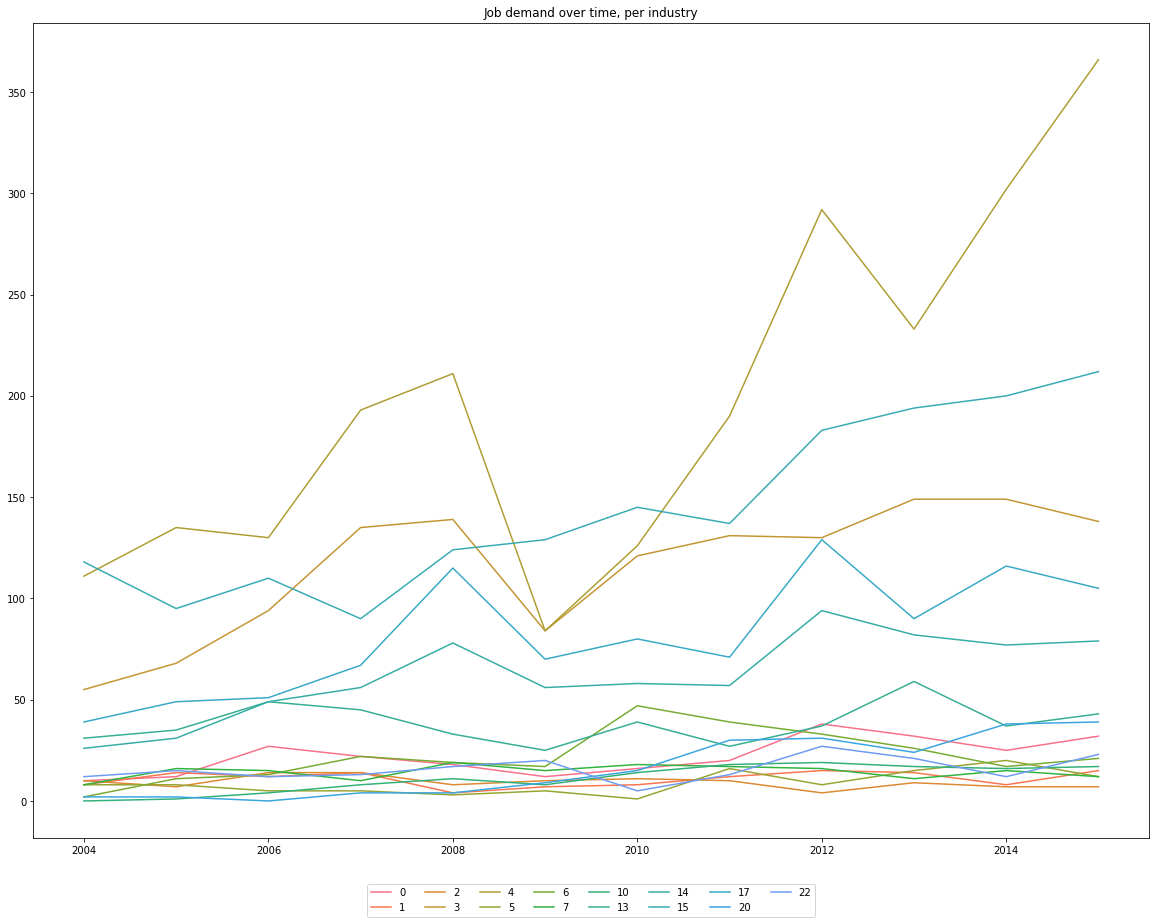

In [145]:
%matplotlib inline
fig, axs = plt.subplots(nrows=1, figsize=(20,15))

sns.set_palette("husl", 20)  # oooh, pretty

datedf.plot(ax=axs)

axs.set_title('Job demand over time, per industry')

L=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=int(num_clusters/3))
#for i in clusterList:
#    L.get_texts()[clusterList.index(i)].set_text(firsttopword[i])